In [1]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
# Loading the data
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST(root="../data",
                                            train=True, download=True, transform=transforms.Compose([
                                                transforms.ToTensor(), 
                                                transforms.Normalize((0.1307,),
                                                                    (0.3081,))
                                                ])
                                            ), batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST(root="../data",
                                            train=False, download=True, transform=transforms.Compose([
                                                transforms.ToTensor(), 
                                                transforms.Normalize((0.1307,),
                                                                    (0.3081,))
                                                ])
                                            ), batch_size=64, shuffle=False)


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(device)


In [4]:
# Training the model

optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.*batch_idx / len(train_loader):.0f}%)]\tLoss:{loss.item():.6f}")

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy:{correct}/{len(test_loader.dataset)} ({100.*correct / len(test_loader.dataset):.0f}%)\n")

In [5]:
# Visualizing the STN results

def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.256])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title("Dataset Images")

        axarr[1].imshow(out_grid)
        axarr[1].set_title("Transformed Images")

for epoch in range(1, 20 + 1):
    train(epoch)
    test()



c:\Users\SB15\miniconda3\envs\aiWs\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\SB15\miniconda3\envs\aiWs\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss:2.352567
Train Epoch: 1 [32000/60000 (53%)]	Loss:0.881508


c:\Users\SB15\miniconda3\envs\aiWs\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2644, Accuracy:9309/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss:0.483230
Train Epoch: 2 [32000/60000 (53%)]	Loss:0.357424

Test set: Average loss: 0.1386, Accuracy:9573/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss:0.224015
Train Epoch: 3 [32000/60000 (53%)]	Loss:0.197922

Test set: Average loss: 0.0907, Accuracy:9706/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss:0.175986
Train Epoch: 4 [32000/60000 (53%)]	Loss:0.242090

Test set: Average loss: 0.0821, Accuracy:9723/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss:0.199495
Train Epoch: 5 [32000/60000 (53%)]	Loss:0.101992

Test set: Average loss: 0.0638, Accuracy:9799/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss:0.157021
Train Epoch: 6 [32000/60000 (53%)]	Loss:0.150457

Test set: Average loss: 0.0636, Accuracy:9803/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss:0.223235
Train Epoch: 7 [32000/60000 (53%)]	Loss:0.104090

Test set: Average loss: 0.0528, Accuracy:9831/10000 (98%)

Train Epoch: 8 [0/6000

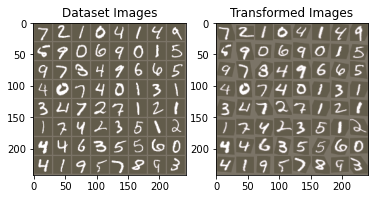

In [6]:
visualize_stn()

plt.ioff()
plt.show()